# Spectrum calculation

This section focuses on the calculation of XPS, XAS, XES, and RIXS, mainly by considering these spectroscopies at the ADC and TDDFT levels of theory. For a more general overview of the large number of methods available to determine these properties, see, *e.g.*, {cite}`xrayrev2018`.

In [1]:
import copy
import adcc
import gator
import matplotlib.pyplot as plt
import multipsi as mtp
import numpy as np
import veloxchem as vlx
from matplotlib import gridspec
from scipy.interpolate import interp1d
import py3Dmol as p3d

# au to eV conversion factor
au2ev = 27.211386

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
# These will be removed and included through VeloxChem

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy,
                                    end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = (
                yi[i]
                + y[k] * gamma / ((xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2) / np.pi
            )
    return xi, yi

class MockTask:
    def __init__(self, mol, basis, comm, ostream):
        self.molecule = mol
        self.ao_basis = basis
        self.mpi_comm = comm
        self.ostream = ostream

(sec:xray_calc_xps)=
## X-ray photoemission spectroscopy

In XPS the photoemission of electrons is measured, yielding information on core-electron binding energies. Here we focus on the calculation of ionization energies (IEs), from which the isotropic photoemission spectrum is formed by giving each IE the same intensity and then broadening with an appropriate convolution function. It is possible to go beyond such a simple approach using Dyson orbitals, but it typically does not make much of a difference {cite}`ccsdDyson2019`. 


(sec:xray_calc_iekoop)=
### IEs from Koopmans' theorem

A simple model for calculating ionization energies and electron affinities is by using Koopmans' theorem, where they are estimated from the MO energies. For water, we then obtain a $1s$ IE of:

In [3]:
water_xyz = """3

O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [4]:
viewer = p3d.view(width=300, height=200)
viewer.addModel(water_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(-90,'x')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver()
scf_results = scf_gs.compute(molecule, basis)

# Extract orbital energies
orbital_energies = scf_results["E_alpha"]

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [6]:
print(f'1s IE from Koopmans\' theorem: {au2ev * orbital_energies[0]: 5.2f} eV')

1s IE from Koopmans' theorem: -559.50 eV


This can be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of [relaxation](sec:xray_topics_relax), which results from the reorganization of the valence electrons in response to a reduction in screening of the nuclei. By comparison, in valence spectroscopies the change in shielding is significantly smaller, yielding far smaller errors due to the lack of relaxation.

An approach for including relaxation effects in IE calculations is to use the $\Delta\textrm{SCF}$ approach, in which the difference in total energy between the neutral and explicitly optimized core-hole states yields estimates of core-electron binding energies. 

### The maximum overlap method

In a normal SCF cycle without constraints, the core-ionized state is not possible to converge since it collapses into a lower-energy valence-ionized state. To obtain a core-hole state, an approach which avoids the convergence to the valence-hole state is needed. This can be done using several approaches, but the focus here will be on the maximum overlap method (MOM). The idea behind MOM is to run an SCF optimization with the constraint of maximizing the overlap of the orbitals to some initial guess {cite}`mom1961, mom1967, mom1971, maxover2008`. The guess is typically taken as the converged wave function of the neutral (no core-hole) system, and new occupied orbitals at each iteration are chosen such that they overlap most with the span of old occupied orbitals. Defining the overlap matrix as

$$
\textbf{O} = 
\left( \textbf{C}^{\textrm{old}} \right)^{\dagger} \textbf{SC}^{\textrm{new}}
$$

with $O_{ij}$ being the overlap between the $i$:th old and $j$:th new orbital, and $\textbf{C}$ and $\textbf{S}$ are the MO coefficient matrices and basis function overlap matrix, respectively. The projections of the $j$:th new orbital onto the old space is

$$
p_j = \sum_i^n O_{ij} = 
\sum_a^N (
\sum_b^N (
\sum_i^n C_{ib}^{\textrm{old}} )
S_{bc} )
C_{cj}^{\textrm{old}}
$$

The occupied orbitals are then selected by largest $p_j$ values. The original formulation of MOM used the previous iteration as the old space, but more recent development (and what is used in VeloxChem) includes the use of the initial guess as the old space throughout - this is also referred to as initial maximum overlap method (IMOM).

With this, a converged core-hole wave-function is obtained with the following scheme:

1. Calculate the wave-function of the original system (*e.g.* no core-hole).

2. Use this as a starting guess for a new wave-function optimization, removing an electron from the desired orbital (and potentially occupying some other virtual orbital).

3. Optimize this state using the MOM restriction.

This scheme can consider many unstable states, including core-ionized and certain core-excited states. Some care should be observed, though:

- If excited states are considered, check that the final state is reasonably close to what is to be investigated.

- [Delocalized core orbitals](sec:xray_topics_chloc) need to be localized, for example by employing ECPs.

- If post-HF methods are used, the ground state calculation can attempt to (partially) fill the core-hole of the [non-*Aufbau* reference state](sec:xray_topics_nonaufbau), leading to a corrupt wave-function which represents an intermediate between a core-hole/valence-hole state.


(sec:xray_calc_dscf)=
### IEs from $\Delta$SCF

The IE of water using $\Delta\textrm{SCF}$ is then computed as:

In [7]:
# Copy molecule object
mol_ion = copy.deepcopy(molecule)

# Change charge and multiplicity
mol_ion.set_charge(1)
mol_ion.set_multiplicity(2)

# Lists of occupied alpha and beta MOs
occa = [0, 1, 2, 3, 4]
occb = [1, 2, 3, 4]

# Calculate SCF of core-ion
scf_ion = vlx.ScfUnrestrictedDriver()
scf_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
scf_ion_results = scf_ion.compute(mol_ion, basis)

                                                                                                                          
* Info * Checkpoint written to file: veloxchem_scf_2023-05-30T09.12.05.scf.h5                                             
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Unrestricted Hartree-Fock                                       
                   Initial Guess Model             : Restart from Checkpoint                                              
                   Convergence Accelerator         : Direct Inversion of Iterative Subspace                               
                

In [8]:
# IE from energy difference
hf_ie = au2ev * (scf_ion.get_scf_energy() - scf_gs.get_scf_energy())
print(f'HF ionization energy: {hf_ie : 5.2f} eV')

HF ionization energy:  541.73 eV


This estimate is within 2 eV from experiment, and we can include electron correlation using MP2:

In [9]:
mp2_gs = vlx.Mp2Driver()
mp2_gs.compute_conventional(molecule, basis, scf_gs.mol_orbs)

mp2_ion = vlx.Mp2Driver()
mp2_ion.compute_conventional(molecule, basis, scf_ion.mol_orbs)

mp2_ie = au2ev * ((scf_ion.get_scf_energy() + mp2_ion.e_mp2) - (scf_gs.get_scf_energy() + mp2_gs.e_mp2))
print(f'MP2 ionization energy: {mp2_ie : 5.2f} eV')

MP2 ionization energy:  542.86 eV


```{warning}
Above will be changed, as it currently is using MP2 (not UMP2).
```

Alternatively, we can consider this with KS-DFT:

In [10]:
# Perform SCF calculation
dft_gs = vlx.ScfRestrictedDriver()
method_settings = {"xcfun": "b3lyp"}
dft_gs.update_settings({}, method_settings)
dft_results = dft_gs.compute(molecule, basis)

# Calculate SCF of core-ion
dft_ion = vlx.ScfUnrestrictedDriver()
dft_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
dft_ion.update_settings({}, method_settings)
dft_ion_results = dft_ion.compute(mol_ion, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [11]:
# IE from energy difference
dft_ie = au2ev * (dft_ion.get_scf_energy() - dft_gs.get_scf_energy())
print(f'DFT ionization energy: {dft_ie : 5.2f} eV')

DFT ionization energy:  542.58 eV


MP2 and DFT currently bring us *away* from experiment when comparing to HF, but we note that the basis set is small and ill-suited for core properties. Using a cc-pCVTZ basis we obtain:

| method | IE [eV] |
|---|---|
| HF  | 538.93  |
| MP2  | 540.26  |
| B3LYP  | 539.19  |


Thus closer to experiment for the correlated methods (note that [scalar-relativistic effects](sec:xray_topics_rel) will shift these results upwards by $\sim$0.37 eV).

%
%
%
Note: verify above
%
%
%

### Spectra from $\Delta\textrm{SCF}$

The X-ray photoemission spectrum can be formed by computing all relavant core-electron binding energies (IEs), giving each unique ionization equal intensity, and broadening over the result with an appropriate convolution function.

We here consider ethyl trifluoroacetate( (CF$_3$-CO-O-CH$_2$-CH$_3$), also known as the ['ESCA' molecule](https://doi.org/10.1016/j.elspec.2012.05.009), which possess very illustrative shifts in XPS features of the carbon $K$-edge due to interactions with the very electronegative oxygen and fluorine atoms. We calculate the four carbon 1s IEs with $\Delta\textrm{SCF}$:

In [12]:
esca_xyz = """14

C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
"""

# Create veloxchem mol and basis objects
molecule = vlx.Molecule.read_xyz_string(esca_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [13]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(esca_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

```python
# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver()
scf_gs.compute(molecule, basis)
nocc = molecule.number_of_alpha_electrons()

# Copy molecule object
mol_ion = copy.deepcopy(molecule)

# Change charge and multiplicity
mol_ion.set_charge(1)
mol_ion.set_multiplicity(2)

esca_ies = []
for n in [5, 6, 7, 8]:
    occa = list(np.arange(nocc))
    occb = copy.copy(occa)
    occb.remove(n)
    scf_ion = vlx.ScfUnrestrictedDriver()
    scf_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
    scf_ion_results = scf_ion.compute(mol_ion, basis)
    hf_ie = au2ev * (scf_ion.get_scf_energy() - scf_gs.get_scf_energy())
    esca_ies.append(hf_ie)

print(esca_ies)
```

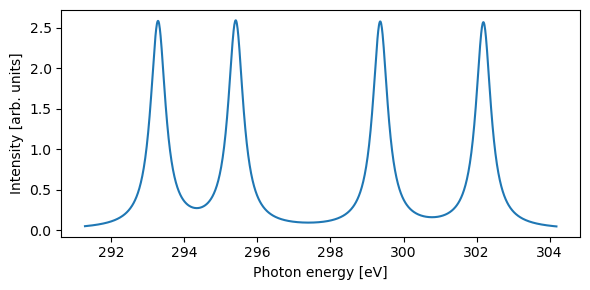

In [14]:
# IEs from above calculation
esca_ies = [302.187, 299.362, 295.405, 293.277]

# Broaden with a Lorentzian and plot
plt.figure(figsize=(6, 3))
x, y = esca_ies, np.ones((len(esca_ies)))
# Lorentzian function takes energies, intensities, energy range, step-size, and a broadening parameter
xi, yi = lorentzian(x, y, min(x) - 2, max(x) + 2, 0.01, 0.5)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Intensity [arb. units]")
plt.tight_layout()
plt.show()

For the comparison to [experimental measurements](https://doi.org/10.1016/j.elspec.2012.05.009), a cc-pVTZ basis set is selected, as augmented with additional core-polarizing functions for the carbon atoms (*i.e.* cc-pCVTZ). Theoretical spectrum shifted by 0.11 eV (to account for relativistic effects) and broadened by 0.3 eV.

```{figure} ../../img/xray/esca_xps.svg
---
name: esca_xps
---
```

The features originate in, from low to high energy: H$_3$**C**-, -**C**H$_2$-, -**C**O-, and -**C**F$_3$. We note a good agreement for the first two features, but the comparison deteriorates for higher energies. This is largely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which the current level of theory is not capable of describing as well.


(sec:xray_calc_xas)=
## X-ray absorption spectroscopy

In XAS the energy-dependent photoabsorption of the sample is measured, probing excitation of core electrons to bound or continuum states. These two different final states then provide information on unoccupied states and local chemical environment, respectively, with a prototypical spectrum of a conjugated system: 


```{figure} ../../img/xray/xafs.svg
---
name: xafs
---
```

We see two disctinct regions with different features and physical origins:

- **NEXAFS (near-edge X-ray absorption fine structure):** the region in which transitions to bound states occurs (this region is also known as XANES, X-ray absorption near-edge structure).

- **EXAFS (extended X-ray absorption fine structure):** which consists of transitions to continuum states, as modulated by constructive or destructive interference between the emitted electron and the environment. This thus provide information on local chemical bonds.

Included is also the position of the IE, as well assignment of typical features ($\pi^*$, Rydberg, and $\sigma^*$). Transitions to $\pi^*$ states are typically low in energy and very intense, and thus easy to identify. By comparison, Rydberg states are typically weak and converge to the ionization energy, and for condensed phase they tend to be atttenuated. Finally, transitions to $\sigma^*$ states can be found above the ionization energy.

The total spectrum is referred to as the **XAFS (X-ray absorption fine structure)** region. For the remainder of this tutorial we will focus on NEXAFS, for which good starting points for modeling with ADC and TDDFT can be found in {cite}`cvsadc32015, coretddft2010, xrayrev2018`.


(sec:xray_calc_cvs)=
### Decoupling from the valence continuum

A complication that arises when considering core excitations is the embedding of the core-excited states in the continuum of valence-ionized states. This means that the targetted core-excited states cannot easily be resolved with, *e.g.*, a Davidson approach, as a large number of valence-excited and -ionized states need to be converged first. A number of approaches have been developed to remove or circumvent this issue, including:

- The core-valence separation (CVS) approximation {cite}`cederbaum1980, cvsadc32015, cvseomccsd2019`

- Restricted energy window (which is largely a different flavour of CVS) {cite}`rttddft2012`

- Damped linear response theory, or the complex polarization propagator (CPP), where the response at arbitrary frequencies is directly probed {cite}`cppdft1`

- Real-time propagation of the electronic structure {cite}`rttddft2012`

Alternatively, when using methods constructing explicit excited states this can be avoided by some constraint scheme, such as MOM.

```{warning}
Within a damped response framework and when using real-time propagation there can be [spurious mixing](sec:xray_cons_spur_val) with valene-ionized states, which needs to be avoided.
```


The focus in this tutorial is the use of the CVS approximation and the CPP approach, with which interior eigenstates and response at arbitrary frequencies can be addressed, as illustrated below. Here we show the global spectrum of water, using the 6-311G basis set. Results obtained with ADC(1), CVS-ADC(1), ADC(2), CVS-ADC(2), and CPP-DFT. CPP-DFT results obtained using the B3LYP exchange-correlation functional and a large $\gamma$ of 1 eV. ADC results are shown as bar spectra.


```{figure} ../../img/xray/cvs_adc.svg
---
name: global_xray
---
```

Here we see the global spectrum of water, using a rather limited basis set. Even so, ADC(1) requires more than 50 states to resolve the core-excitation region (situated at about 535 eV for water), and for ADC(2) we could only converge abot 50 states, which did not bring us to the core-excitations. With the CVS approximation we directly target the core-excitation region, albeit at the cost of introducing an error. However, this error has been shown to be relatively small (provided a reasonable basis set) and stable for ADC {cite}`Herbst2020`, and for TDHF and TDDFT it is all but negligible. Using CPP-DFT, this error is avoided all together (although CPP-ADC has been noted to be hard to converge for core-excited state {cite}`gator`, so here CVS-CPP-ADC might instead be used - thus reintroducing this small error).


(sec:xray_calc_cvsadc)=
### Spectra from CVS-ADC

With CVS-ADC, the core-excitation spectrum is calculate by specifying the index of the probed core orbitals(s):

In [15]:
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Construct structure and basis objects
struct = gator.get_molecule(water_mol_str)
basis = gator.get_molecular_basis(struct, "6-31G")

# Perform SCF calculation
scf_results = scf_gs = gator.run_scf(struct, basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_result = gator.run_adc(
    struct, basis, scf_gs, method="cvs-adc2x", singlets=4, core_orbitals=1
)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

The results can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening:

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0178       0.8       0.2  |
|  1       19.7967      538.6956   0.0373    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0099    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1016    0.8441    0.1559  |
+--------------------------------------------------------------+



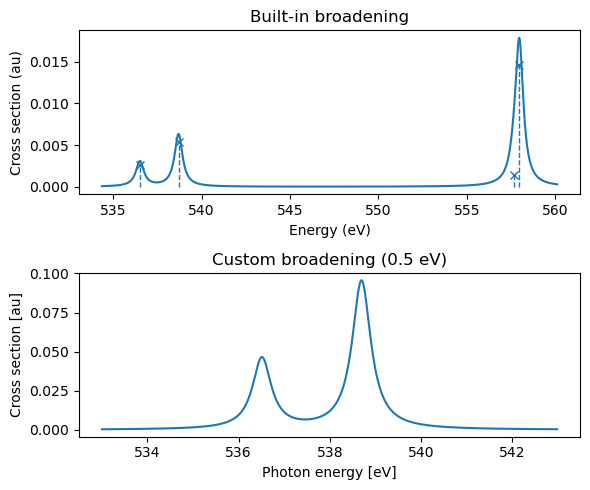

In [16]:
# Print information on eigenstates
print(adc_result.describe())

plt.figure(figsize=(6, 5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211)
plt.title("Built-in broadening")
adc_result.plot_spectrum()

# Manually convoluted using excitation energies and oscillator strengths
plt.subplot(212)
plt.title("Custom broadening (0.5 eV)")
x, y = au2ev * adc_result.excitation_energy, adc_result.oscillator_strength
xi, yi = lorentzian(x, y, 533, 543, 0.01, 0.5)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Cross section [au]")
plt.tight_layout()
plt.show()

The built-in functionality uses a Lorentzian broadening with a small broadening parameter, and plots the full region which is resolved, while we might want to focus on lower-energy regions and use custom broadening schemes (as done in the lower panel). We note that high-energy features can often be a result of a discretized continuum region, as seen by the unphysically intense feature at $\sim$558 eV. A larger basis set will flatten out this region, but care should be taken for any analysis above the ionization energy.

Increasing the basis set to aug-cc-pCVTZ/cc-pVTZ (for oxygen and hydrogen, respectively), we obtain results in good agreement with [experiment](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.47.1136). Here the theoretical spectra has been shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.3 eV.


```{figure} ../../img/xray/adc_water_xas.svg
---
name: adc_water_xas
---
```

(sec:xray_calc_cvsdft)=
### Spectra from TDDFT

RPA and TDA calculations:

In [17]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = "b3lyp"
scf_drv.grid_level = 4
scf_result = scf_drv.compute(molecule, basis)

rpa_drv = vlx.LinearResponseEigenSolver()
rpa_drv.core_excitation = True
rpa_drv.num_core_orbitals = 1
rpa_drv.update_settings({"nstates": 6}, method_settings)
rpa_result = rpa_drv.compute(molecule, basis, scf_result)

tda_drv = vlx.TdaEigenSolver()
tda_drv.core_excitation = True
tda_drv.num_core_orbitals = 1
tda_drv.update_settings({"nstates": 6}, method_settings)
tda_result = tda_drv.compute(molecule, basis, scf_result)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

Plotting the results:

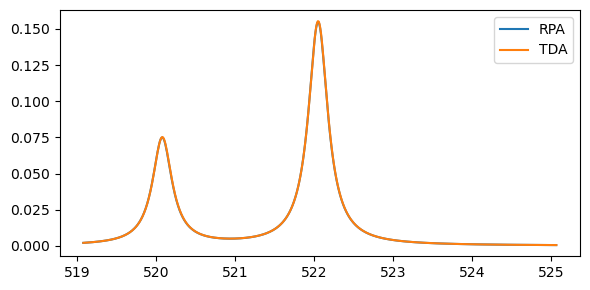

In [18]:
plt.figure(figsize=(6, 3))
# RPA results
x = 27.2114*rpa_result['eigenvalues']
y = rpa_result['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1,min(x)+5,0.01,0.3)
plt.plot(xi,yi)
# TDA results
x = 27.2114*tda_result['eigenvalues']
y = tda_result['oscillator_strengths']
xi,yi = lorentzian(x,y,min(x)-1,min(x)+5,0.01,0.3)
plt.plot(xi,yi)
plt.legend(('RPA','TDA'))
plt.tight_layout()
plt.show()

(sec:xray_calc_cppdft)=
### Spectra from CPP-DFT

With the complex polarization propagator (CPP), also called the damped linear response function, the absorption and dispersion spectrum can be evaluated at arbitrary energies {cite}`cpp1`. As such, the X-ray absorption spectrum can be directly calculated by calculating the response at X-ray photon energies. For this, we need to decide on which energy region to use, which can be estimated by, *e.g.*:

- Screening extended energy regions with large step size. This could potentially be done using a smaller basis set.

- With a method lacking relaxation: starting the region a few eV below the IE from Koopmans' theorem. This will not work for methods capable of including relaxation, where IEs from $\Delta$SCF could instead be considered as a first rough estimate (noting that it will work better or worse for different levels of, *e.g.*, ADC theory).

Choosing an energy region of 514-525 eV, using a step length of 0.1 eV and a damping factor of 0.3 eV, we calculate the CPP-DFT (with the B3LYP functional) water spectrum as:

In [19]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and SCF optimization
scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_result = scf_drv.compute(molecule, basis)

# Define spectrum region to be resolved
freqs = np.arange(515.0, 525.0, 0.1) / au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_drv = vlx.rsplinabscross.LinearAbsorptionCrossSection(
    {"frequencies": ",".join(freqs_str), "damping": 0.3 / au2ev}, method_settings
)
cpp_drv.init_driver()
cpp_result = cpp_drv.compute(molecule, basis, scf_result)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_drv.rsp_property["response_functions"][("x", "x", w)].imag
    ayy = -cpp_drv.rsp_property["response_functions"][("y", "y", w)].imag
    azz = -cpp_drv.rsp_property["response_functions"][("z", "z", w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

Resulting spectra can be plotted as raw, or splined for smoother figures:

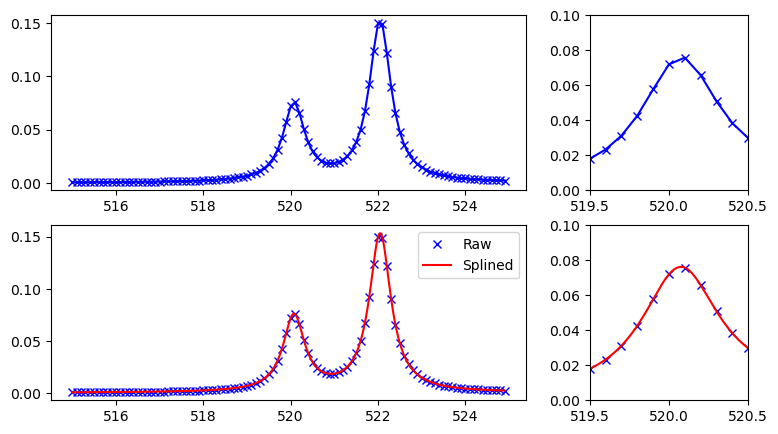

In [20]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev * freqs, sigma, "bx-")

# Raw results for a zoomed-in region
plt.subplot(gs[1])
plt.plot(au2ev * freqs, sigma, "bx-")
plt.xlim((519.5, 520.5))
plt.ylim((0, 0.10))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev * freqs, sigma, "bx")
x = np.arange(min(au2ev * freqs), max(au2ev * freqs), 0.01)
y = interp1d(au2ev * freqs, sigma, kind="cubic")
plt.plot(x, y(x), "r")
plt.legend(("Raw", "Splined"))

# Raw and splined spectra for a zoomed-in region
plt.subplot(gs[3])
plt.plot(au2ev * freqs, sigma, "bx")
plt.plot(x, y(x), "r")
plt.xlim((519.5, 520.5))
plt.ylim((0, 0.10))
plt.show()

Using broadened eigenstates, increasing the basis set size and comparing to [experiment](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.47.1136) we get the following, where theoretical spectrum has been shifted by 14.5 eV and broadened by 0.3 eV:

```{figure} ../../img/xray/dft_water_xas.svg
---
name: dft_water_xas
---

```

As can be seen, the absolute excitation energies are significantly off, with a shift of 14.5 eV required to yield an approximate alignment to experiment. Part of this shift is due to lack of relativistic effects (~0.37 eV), and a small discrepancy can be expected due to the use of a limited basis set, but the main part of the error is due to two effects:

1. Lack of [relaxation](sec:xray_topics_relax), which yields a final state too high in energy and thus shifts the theoretical spectra upwards in energy.

2. The self-interaction error ([SIE](sec:xray_topics_sie)), which yields an erroneous self-repulsion of the dense core orbitals, and results in too low core-excitation energies.

For B3LYP, the combined effect of these two errors results in too low transition energies, meaning that the SIE dominates. By changing the amount of HF exchange, this balance will shift and the error eventually becomes positive.

Despite this large absolute error, the TDDFT spectrum is in reasonable agreement with experiment once it has been shifted. In general, different xc-functionals [can exhibit](sec:xray_precision) good precision (relative errors), despite poor accuracy (absolute errors), such that a constant shift in energy can be applied.

### Spectra from CPP-CASSCF

In [21]:
# Prepare molecule and basis objects
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.cas_orbitals([2,3,5,6])

mcscf_drv = mtp.McscfDriver()
mcscf_results = mcscf_drv.compute(molecule, basis, space)

mcscf_cpp = mtp.Mclr_CPPsolver()
mcscf_cpp.set_damping(0.3)
mcscf_cpp.set_frequency_range(540,550,step_size=0.1)
rspdict = mcscf_cpp.compute(molecule, basis, mcscf_drv)

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-specific calculation
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                                                          

          Active space def

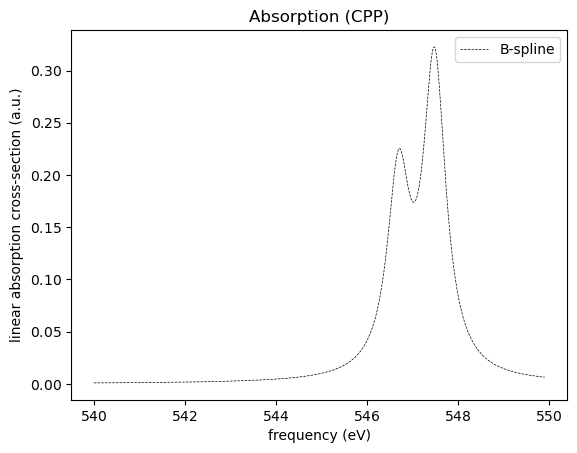

In [22]:
mcscf_cpp.produce_plot()

(sec:xray_calc_xes)=
## X-ray emission spectroscopy

Following the creation of a core-hole, the system will rapidly ($\sim$fs) decay to a valence-hole or valence-excited state, depending on whether the system is core-ionized or core-excited. These two different intermediate states  are probed when the X-ray pulse is in resonance (excited regime) or not (ionized regime), yielding resonant/non-resonant X-ray emission spectroscopy. This section will focus on the latter, with the former following in the [next section](sec:xray_calc_rixs).

In the decay process the system gains large amounts of energy which need to be discarded, as can occur by emission of high-energy photons (fluorescence) or high-lying electrons (Auger), with relative probability depending on edge and element. For the *K*-edge the relative probabilities follow the following trends, with figure taken from [wikipedia.org](https://commons.wikimedia.org/wiki/File:Auger_xray_wiki_in_png_format.png):

```{figure} ../../img/xray/auger_vs_fluorescent.png
---
name: auger_vs_fluorescent
---
```

Auger decay dominates for light elements, which has impact on both our ability of obtaining well-resolved spectra for these elements, as well as the impact of X-ray damage on biological matter.

In non-resonant XES we measure the fluorescent decay of core-ionized states, through which we probe the (element-specific) nature of the local chemical environment. For light elements, the valence space is probed directly, but for heavier elements we obtain a number of different decay channels from the valence region and the outer core region. These lines vary considerably in energy, intensity, and sensitivity to local environment {cite}`guideXray2016`:

1. The $2p \rightarrow 1s$ ($K\alpha_1$ and $K\alpha_2$) lines are most intense (due to the large overlap) and of lowest energy, and relatively insensitive to the valence region

2. The $3p \rightarrow 1s$ ($K\beta ' $ and $K\beta_{1,3}$) lines are higher in energy and more sensitive to the local environment than $K\alpha$, but about an order of magnitude weaker.

3. Transitions from the ligand MOs ($K\beta '' $ and $K\beta_{2,5}$), or valence-to-core (VtC), yield the weakest, highest-energy features, which are the most sensitive to the local environment


This tutorial focuses on spectra of light elements, as modelled by ground state DFT, TDDFT, and ADC. Good starting points for learning about such modeling techniques can be found in {cite}`coretddft2010, adcxes2019, dftXray2021`.


(sec:xray_calc_xesadc)=
### Spectra from ADC

One approach for considering X-ray emission spectra is to converge a core-hole state and use this core-ionized system as the reference state for a normal excited state calculation {cite}`coretddft2010, adcxes2019`. The core-decay transitions are then the first negative eigenstates of the system, such that a standard Davidson calculation can be run on top of this reference state.

Considering water with ADC(2), the oxygen X-ray emission spectrum is calculated as:

```{note}
Currently considering double-core-hole, as adcc cannot yet use an unrestricted SCF from VeloxChem.
```

In [23]:
# Create veloxchem mol and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-311G")

# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver()
scf_result = scf_gs.compute(molecule, basis)

# Copy molecule object
mol_ion = copy.deepcopy(molecule)

# Change charge and multiplicity
mol_ion.set_charge(2)
mol_ion.set_multiplicity(1)

# Lists of occupied alpha and beta MOs
occa = [1, 2, 3, 4]
occb = [1, 2, 3, 4]

# Calculate SCF of core-ion
scf_ion = vlx.ScfRestrictedDriver()
scf_ion.maximum_overlap(mol_ion, basis, scf_gs.mol_orbs, occa, occb)
scf_ion_result = scf_ion.compute(mol_ion, basis)

# IE from energy difference
hf_ie = au2ev * (scf_ion.get_scf_energy() - scf_gs.get_scf_energy())

# Set up mock task for adcc
task = MockTask(mol_ion, basis, scf_ion.comm, scf_ion.ostream)
scf_ion.task = task

# Four lowest (negative) eigenstates
adc_xes = adcc.adc2(scf_ion, n_states=4)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-311G       
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-311G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

```{tip}
There may be convergence issues if you include transitions of very different types, *e.g.* when resolving transitions into the core and out to the unoccupied valence region simultaneously. As such, the number of required states should not be too high.
```

The results can be printed as a table, and convoluted and plotted using built-in functionalities or a custom broadening. Note that the eigenvalues are negative, and a sign change is thus appropriate when constructing the spectra.

+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     -22.20632     -604.2647   0.0000    0.9644   0.03563  |
|  1     -22.15933      -602.986   0.0000    0.9622   0.03785  |
|  2     -22.09183     -601.1495   0.1612    0.9588   0.04123  |
|  3     -22.04624     -599.9086   0.1409    0.9561   0.04391  |
+--------------------------------------------------------------+



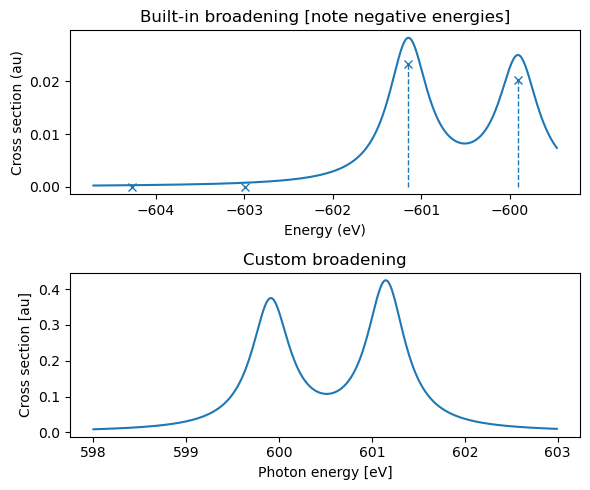

In [24]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6, 5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211)
plt.title("Built-in broadening [note negative energies]")
adc_xes.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212)
plt.title("Custom broadening")
x, y = -au2ev * adc_xes.excitation_energy, adc_xes.oscillator_strength
xi, yi = lorentzian(x, y, 598, 603, 0.01, 0.5)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Cross section [au]")
plt.tight_layout()
plt.show()

Using a cc-pCVTZ/cc-pVTZ basis set and comparing to [experiment](https://aip.scitation.org/doi/10.1063/1.3702644), where theoretical spectrum shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.3 eV:

```{figure} ../../img/xray/adc_water_xes.svg
---
name: adc_water_xes
---
```

While the broadening between the different lines is noticeably different, it is clear that the energy spacing and integrated intensities of the features are in good agreement with experiment. The theoretical spectrum is obtained at the ADC(2) level of theory, which has been seen to yield better absolute energies than ADC(2)-x and ADC(3/2) (for XES) {cite}`adcxes2019`.

(sec:xray_calc_xesdft)=
### Spectra from TDDFT


```{note}
To be added.
```

(sec:xray_calc_xesmos)=
### Spectra from ground state MOs

While we have previously seen that Koopmans' theorem is in significant disagreement with experimental ionization energies (due to lack of relaxation), it has been noted that the *relative* position of the (valence) MO energies can still be quite reasonable {cite}`dftXray2021`. As such, a computationally simple approach for modeling X-ray emission spectra has been developed, in which transition energies are estimated from:

$$
\Delta E = \epsilon_v - \epsilon_c
$$

*i.e.* from the difference in ground state MO energies. The intensities are taken to be proportional to the transition dipole moment:

$$
f \propto | \langle \phi_i | \hat{\mu} | \phi_c \rangle | ^2
$$

This independent-particle picture method is very attractive in its simplicity, requiring only a single ground state calculation and the construction of a number of transition dipole moments in order to construct the full spectrum. However, the absolute energies are significantly off, and any differences in relaxation between the different channels will not be accounted for, and multichannel and many-body effects are neglected. Nevertheless, this approach has been noted to yield good (relative) agreement to experimental measurements, and it is capable of considering even massive molecular systems.

The calculation of an emission spectra thus requires the calculation of the ground state and of all relevant transition dipole moments:

In [25]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_result = scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [26]:
# Extract orbital energies and number of occupied MOs
orbital_energies = scf_result["E_alpha"]
nocc = molecule.number_of_alpha_electrons()
print("Occupied MO energies:", au2ev * orbital_energies[:nocc])

# Define probed core MO and calculate energy differences
n_core = 0
energy_diff = []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        energy_diff.append(au2ev * (orbital_energies[n_mo] - orbital_energies[n_core]))

# Extract MO coefficients
mo_C = scf_result["C_alpha"]

# Load drivers for transition dipole moment
dipole_drv = vlx.ElectricDipoleIntegralsDriver()

# Calculated transition dipole moments and convert to MO basis
dipole_matrices = dipole_drv.compute(molecule, basis)
x_ao = dipole_matrices.x_to_numpy()
x_mo = np.matmul(mo_C.T, np.matmul(x_ao, mo_C))
y_ao = dipole_matrices.y_to_numpy()
y_mo = np.matmul(mo_C.T, np.matmul(y_ao, mo_C))
z_ao = dipole_matrices.z_to_numpy()
z_mo = np.matmul(mo_C.T, np.matmul(z_ao, mo_C))

# Construct oscillator strengths
xx, yy, zz, sigma = [], [], [], []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        x_tmp, y_tmp, z_tmp = x_mo[n_core, n_mo], y_mo[n_core, n_mo], z_mo[n_core, n_mo]
        xx.append(x_tmp)
        yy.append(y_tmp)
        zz.append(z_tmp)
        sigma.append(x_tmp ** 2 + y_tmp ** 2 + z_tmp ** 2)

Occupied MO energies: [-520.65707757  -27.6878829   -14.39950787   -9.70379307   -7.94953867]


The results can be printed as a table, and convoluted and plotted using a custom broadening. We here focus on the high-energy features:

Energy   Osc. str.   x-component   y-component   z-component
492.969   0.00022     -0.00000       0.00000      -0.01478
506.258   0.00238     -0.04878      -0.00000       0.00000
510.953   0.00255     -0.00000       0.00000       0.05050
512.708   0.00342      0.00000      -0.05848      -0.00000


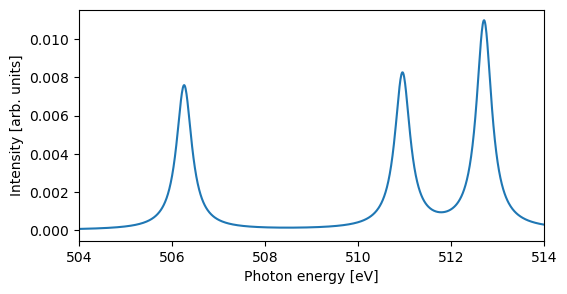

In [27]:
# Print results as a table
print("Energy   Osc. str.   x-component   y-component   z-component")
for i in np.arange(len(energy_diff)):
    e, os, x, y, z = energy_diff[i], sigma[i], xx[i], yy[i], zz[i]
    print(
        "{:.3f}  {:8.5f}     {:8.5f}      {:8.5f}      {:8.5f}".format(e, os, x, y, z)
    )

# Plot X-ray emission spectrum
plt.figure(figsize=(6, 3))
x, y = energy_diff, sigma
xi, yi = lorentzian(x, y, min(x) - 5, max(x) + 5, 0.01, 0.4)
plt.plot(xi, yi)
plt.xlabel("Photon energy [eV]")
plt.ylabel("Intensity [arb. units]")
plt.xlim((504, 514))
plt.show()

Using a cc-pCVTZ/cc-pVTZ basis set and comparing to experiment {cite}`gaswaterrixs2012`, where theoretical spectrum shifted by 15.5 eV and broadened by 0.3 eV:

```{figure} ../../img/xray/overlap_water_xes.svg
---
name: /overlap_water_xes
---
```

The resulting spectrum has poor absolute energies, but the relative agreement to experiment is quite impressive.

(sec:xray_calc_rixs)=
## Resonant inelastic X-ray scattering

We will here focus on calculating the electronic part of the RIXS plane, and skip cases where one is more interested in probing vibrational modes.

(sec:xray_calc_2stepadc)=
### Two-step approach with ADC

An approximate treatment of the RIXS plane can be achieved by considering it as a two-step process {cite}`adcwaterrixs2018`, with:

1. A core-excitation as modeled like a normal X-ray absorption spectrum

2. A core-decay process from the core-hole system with an electron put in each relevant final state probed in (1), modeled as a (non-resonant) X-ray emission spectrum

The RIXS plane is then constructed from the above absorption and emission energies, with the RIXS intensity from the multiplication of the two respective oscillator strengths.

Note that this approach is an approximation, as it disregards potentially important detuning effects. In the example given below we also ignore the coupling between the polarization of the incoming and outgoing photons. Furthermore, the calculation requires the convergence of core-excited states, which is much trickier than core-ionized, and will likely only work for the first few core-excited states. Finally, depending on how the intermediate core-excited state is constructed, issues with spin-contamination can become highly influential.

Nevertheless, the scheme is quite easy to understand, and introducing core-excited dynamics is relatively straightforward. As such, we here illustrate how the RIXS plane of water can be constructed. First, calculate the X-ray absorption spectrum, as well as the emission spectra with a core-excited reference state:

```{note}
This is to be updated, once adcc can import an UHF object from VeloxChem.
```


```python
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "6-31G"
mol.build()

# Perform restricted SCF calculation
scf_gs = scf.RHF(mol)
scf_gs.kernel()

# Calculate X-ray absorption spectrum
adc_xas = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=1)
print(adc_xas.describe())

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Calculate resonant X-ray emission spectrum
#   for states where the core-electron is moved to LUMO or LUMO+1
adc_rxes = []
for n in [5, 6]:
    # Copy molecular orbitals
    mo0 = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Move 1s electron to LUMO / LUMO+1
    occ0[0][0] = 0.0
    occ0[0][n] = 1.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Calculate resonant X-ray emission spectrum
    adc_rxes.append(adcc.adc2(scf_ion, n_states=4))
```

Now the correct combinations of transition energies and intensities need to be calculated:

```python
adc_rixs = []

# Probing LUMO and LUMO+1
for indx in [0, 1]:
    # From XAS calculation
    E_xas = au2ev * adc_xas.excitation_energy[indx]
    I_xas = adc_xas.oscillator_strength[indx]
    # From XES calculation
    for i in np.arange(len(adc_rxes[indx])):
        E_xes = -au2ev * adc_rxes[indx].excitation_energy[i]
        I_xes = adc_rxes[indx].oscillator_strength[i]
        adc_rixs.append([E_xas, E_xes, I_xas * I_xes])
```

And the RIXS plane can then be plotted:

```python
plt.figure(figsize=(8, 6))
# Plot absorption spectrum
plt.subplot(222)
x, y = au2ev * adc_xas.excitation_energy, adc_xas.oscillator_strength
xi, yi = lorentzian(x, y, min(x) - 2, min(x) + 5, 0.01, 0.3)
plt.plot(yi, xi)

# Plot emission specta, with vertical shift from absorbed energy
plt.subplot(223)
# LUMO
x, y = -au2ev * adc_rxes[0].excitation_energy, adc_rxes[0].oscillator_strength
xi, yi = lorentzian(x, 5.0 * y, x[1] - 9, x[1] + 2, 0.01, 0.3)
plt.plot(xi, yi + au2ev * adc_xas.excitation_energy[0])
# LUMO+1
x, y = -au2ev * adc_rxes[0].excitation_energy, adc_rxes[1].oscillator_strength
xi, yi = lorentzian(x, 5.0 * y, x[1] - 9, x[1] + 2, 0.01, 0.3)
plt.plot(xi, yi + au2ev * adc_xas.excitation_energy[1])

# Plot RIXS plane, here with marker size scaling with intensity
plt.subplot(221)
for i in np.arange(len(adc_rixs)):
    tmp = adc_rixs[i]
    plt.plot(tmp[1], tmp[0], "ok", markersize=10000 * tmp[2])

# Zooming in to region spanned by XAS and XES projections
plt.xlim((519, 530))
plt.ylim((536, 544))

plt.tight_layout()
plt.show()
```


```{figure} ../../img/xray/adc_2st_rixs.svg
---
name: adc_2st_rixs
---
```